cos 함수를 이용하여 데이터 만들기

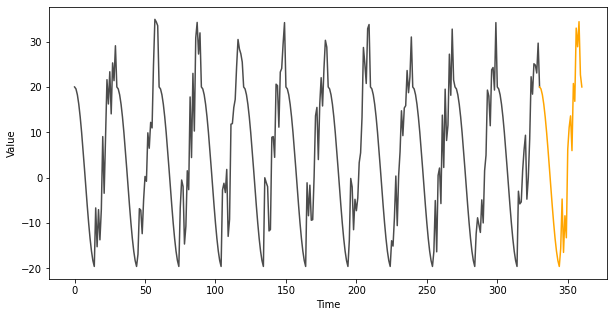

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5, 
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))


plt.figure(figsize = (10, 5)) 
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7) # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange') # 테스트용 데이터

전처리 과정 수행하기

In [ ]:
def make_sequence(time_series, n):
    x_train, y_train = list(), list()
    
    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break
            
    return np.array(x_train), np.array(y_train)

n = 10
x_train, y_train = make_sequence(time_series, n)

x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)

from sklearn.model_selection import train_test_split

patial_x_train = x_train[:30 * 11]
patial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', patial_x_train.shape, patial_y_train.shape) 
print('test:',x_test.shape, y_test.shape)

train: (330, 10, 1) (330, 1)
test: (21, 10, 1) (21, 1)


데이터 형태 확인하기

In [ ]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 10)

for i in range(1, 4):
    print(a[i],'|', b[i])

[ 1  2  3  4  5  6  7  8  9 10] | 11
[ 2  3  4  5  6  7  8  9 10 11] | 12
[ 3  4  5  6  7  8  9 10 11 12] | 13


simpleRNN을 사용하여 모델 구성하기


In [ ]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 층으로 사용하는 경우,
# 반드시 input_shape를 명시해주어야 합니다.
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1)))# activation = 'tanh': 시계열 기본 활성화 함수는 탄젠트
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


모델 학습시키기

In [ ]:
model.fit(x_train, y_train, epochs = 200, batch_size = 12)

Epoch 1/200
30/30 [==============================] - 0s 8ms/step - loss: 253.8216
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 204.5340
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 167.9066
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 143.7438
Epoch 5/200
30/30 [==============================] - 0s 7ms/step - loss: 128.2055
Epoch 6/200
30/30 [==============================] - 0s 7ms/step - loss: 115.5194
Epoch 7/200
30/30 [==============================] - 0s 7ms/step - loss: 106.1641
Epoch 8/200
30/30 [==============================] - 0s 7ms/step - loss: 98.3079
Epoch 9/200
30/30 [==============================] - 0s 7ms/step - loss: 91.2678
Epoch 10/200
30/30 [==============================] - 0s 8ms/step - loss: 84.8357
Epoch 11/200
30/30 [==============================] - 0s 7ms/step - loss: 79.4100
Epoch 12/200
30/30 [==============================] - 0s 7ms/step - loss: 75.5632
Epoch 13/200
30/30

예측 결과 그려보기

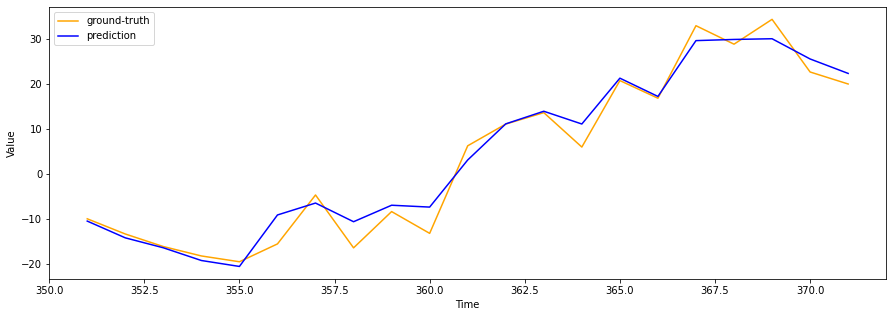

In [ ]:
pred = model.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='ground-truth')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

# 위에 그래프 350 이후부터를 쭉 늘려서 보여주는 것

IMDB 데이터셋 사용하기

In [ ]:
from tensorflow.keras.datasets import imdb

num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500

pad_X_train = pad_sequences(X_train, maxlen=max_len)
pad_X_test = pad_sequences(X_test, maxlen=max_len)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding  

model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 32))
# 새로운 인자 3개가 사용되었습니다.
# return_sequences, dropout, recurrent_dropout
model.add(SimpleRNN(32, return_sequences = True, dropout = 0.15, recurrent_dropout = 0.15))#recurrent_dropout : 뒤로 순환시킬때 몇개를 빼겠다
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))


17465344/17464789 [==============================] - 0s 0us/step


모델 설정하기

In [ ]:
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

모델 학습시키기

In [ ]:
history = model.fit(pad_X_train, y_train, 
                    batch_size = 32, epochs = 15, 
                    validation_split = 0.2)

Epoch 1/15
625/625 [==============================] - 341s 545ms/step - loss: 0.6904 - acc: 0.5357 - val_loss: 0.6179 - val_acc: 0.6790
Epoch 2/15
625/625 [==============================] - 339s 542ms/step - loss: 0.5418 - acc: 0.7301 - val_loss: 0.4798 - val_acc: 0.8074
Epoch 3/15
625/625 [==============================] - 336s 537ms/step - loss: 0.4393 - acc: 0.8078 - val_loss: 0.5970 - val_acc: 0.7546
Epoch 4/15
625/625 [==============================] - 332s 532ms/step - loss: 0.4260 - acc: 0.8117 - val_loss: 0.4881 - val_acc: 0.7868
Epoch 5/15
625/625 [==============================] - 331s 529ms/step - loss: 0.3706 - acc: 0.8432 - val_loss: 0.4688 - val_acc: 0.8142
Epoch 6/15
625/625 [==============================] - 330s 529ms/step - loss: 0.3940 - acc: 0.8307 - val_loss: 0.5189 - val_acc: 0.7792
Epoch 7/15
625/625 [==============================] - 330s 528ms/step - loss: 0.3547 - acc: 0.8526 - val_loss: 0.4586 - val_acc: 0.8134
Epoch 8/15
625/625 [============================